In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage import io
from skimage import color
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)


In [5]:
def Data_load(path):
    #load the mat files 32*32
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = Data_load('/content/drive/MyDrive/train_32x32.mat')
X_test, y_test = Data_load('/content/drive/MyDrive/test_32x32.mat')

print("Train Set", X_train.shape, y_train.shape)
print("Test Set", X_test.shape, y_test.shape)


Training Set (32, 32, 3, 73257) (73257, 1)
Test Set (32, 32, 3, 26032) (26032, 1)


In [6]:
# Imgage Transpose
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

print("Train Set", X_train.shape)
print("Test Set", X_test.shape)
print('')

# Total Images
no_images = X_train.shape[0] + X_test.shape[0]

print("Total Number of Images in dataset", no_images)


Training Set (73257, 32, 32, 3)
Testing Set (26032, 32, 32, 3)

Total Number of Images 99289


In [7]:
def plot_images(img, labels, rows, cols):

    fig, axes = plt.subplots(rows, cols)
    for i, ax in enmerate(axes.flat): 
        if ig[i].shape == (32, 32, 3):
            ax.imshow(ig[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])


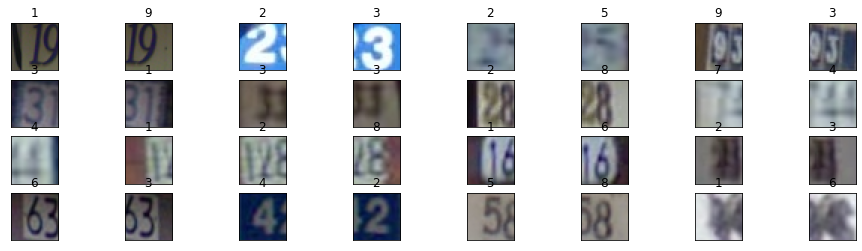

In [8]:
# Ploting "train images"
plot_images(X_train, y_train,4, 8)


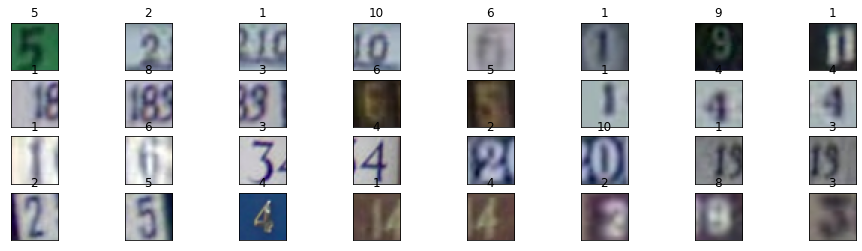

In [9]:
#Ploting "test images"
plot_images(X_test, y_test, 4, 8)


In [10]:
#check unique labels
print(np.unique(y_train))


[ 1  2  3  4  5  6  7  8  9 10]


In [12]:
print(np.unique(y_train))


[0 1 2 3 4 5 6 7 8 9]


In [16]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.13, random_state=7, stratify = y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.13, random_state=7)



In [15]:
y_train.shape, y_val.shape, y_test.shape


((55447,), (8286,), (26032,))

In [17]:
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)
    # Image conversion rgb2grey()
train_Greyscale = rgb2gray(X_train).astype(np.float32)
val_Greyscale = rgb2gray(X_val).astype(np.float32)
test_Greyscale = rgb2gray(X_test).astype(np.float32)


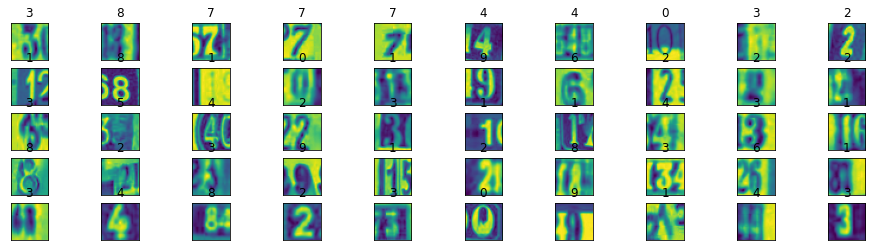

In [18]:
plot_images(train_Greyscale, y_train, 5, 10)


In [19]:
#  mean: training data 
train_mean = np.mean(train_Greyscale, axis=0)

# standard deviation: training data
train_std = np.std(train_Greyscale, axis=0)

# subtract the mean from the greyscale 
train_greyscale_norm = (train_Greyscale - train_mean) / train_std
val_greyscale_norm = (val_Greyscale - train_mean) / train_std
test_greyscale_norm = (test_Greyscale - train_mean)  / train_std

In [20]:
from sklearn.preprocessing import OneHotEncoder
 
# Fit the OneHotEncoder
enc = OneHotEncoder().fit(y_train.reshape(-1, 1))

# Transform the label values to a one-hot-encoding scheme
y_train = ec.transform(y_train.reshape(-1, 1)).toarray()
y_test = ec.transform(y_test.reshape(-1, 1)).toarray()
y_val = ec.transform(y_val.reshape(-1, 1)).toarray()

print("Train data set", y_train.shape)
print("Validation set", y_val.shape)
print("Test data set", y_test.shape)


Training set (48238, 10)
Validation set (7209, 10)
Testing set (26032, 10)


In [21]:
import h5py

#create a file SVHN_grey.h5
h5_file = h5py.File('SVHN_grey.h5', 'w')

# Store the datasets
h5_file.create_dataset('X_train', data=train_greyscale_norm)
h5_file.create_dataset('y_train', data=y_train)
h5_file.create_dataset('X_test', data=test_greyscale_norm)
h5_file.create_dataset('y_test', data=y_test)
h5_file.create_dataset('X_val', data=val_greyscale_norm)
h5_file.create_dataset('y_val', data=y_val)

# Closing the file
h5_file.close()


In [23]:
# Open the file as readonly
h5_file = h5py.File('SVHN_grey.h5', 'r')

# Load the training, test and validation set
X_train = h5_file['X_train'][:]
y_train = h5_file['y_train'][:]
X_test = h5_file['X_test'][:]
y_test = h5_file['y_test'][:]
X_val = h5_file['X_val'][:]
y_val = h5_file['y_val'][:]

# Closing this file
h5_file.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Testing set', X_test.shape, y_test.shape)


Training set (48238, 32, 32, 1) (48238, 10)
Validation set (7209, 32, 32, 1) (7209, 10)
Testing set (26032, 32, 32, 1) (26032, 10)


In [46]:
def get_batch(X, y, batch_size=512):
    for i in np.arange(0, y.shape[0], batch_size):
        end = min(X.shape[0], i + batch_size)
        yield(X[i:end],y[i:end])


In [48]:
def cnn_model_fn(features):
    
      # Input Layer
    input_layer = tf.reshape(features, [-1, 32, 32, 1], name='Reshaped_Input')

      # Convolutional Layer #1 , used relu activation function
    conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)

      # Pooling Layer #1
    #with tf.name_scope('Pool1 Layer'):
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

      # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
        
    #with tf.name_scope('Pool2 Layer'):
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

      # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=256, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=discard_rate)

      # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    return logits

In [49]:
max_epochs = 5
num_examples = X_train.shape[0]


In [50]:
#Model Prediction
prediction = cnn_model_fn(x)
prediction_cls = tf.argmax(prediction, 1)
#loss
loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(
   onehot_labels=y, logits=prediction))
    
# Using Adam Optimizer
optimizer = tf.train.AdamOptimizer().minimize(loss)


In [51]:

correct_prediction = tf.equal(prediction_cls, y_cls)

# mean
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [52]:
Sess = tf.Session()


In [53]:
Sess.run(tf.global_variables_initializer())


In [43]:
## Trainig time
train_loss = []
valid_loss = []
start_time = time.time()
for epoch in range(max_epochs):
    print ('Training .........')
    epoch_loss = 0
    print ()
    print ('Epoch ', epoch+1 , ': ........ \n')
    step = 0   
    
    for (epoch_x , epoch_y) in get_batch(X_train, y_train, batch_size):
        _, train_accu, c = Sess.run([optimizer, accuracy, loss], feed_dict={x: epoch_x, y: epoch_y, discard_rate: discard_per})
        train_loss.append(c)
    
        if(step%40 == 0):
            print ("Step:", step, ".....", "\nMini-Batch Loss   : ", c)
            print('Mini-Batch Accuracy :' , train_accu*100.0, '%')

            ## Validating prediction and summaries
            accu = 0.0
            for (epoch_x , epoch_y) in get_batch(X_val, y_val, 512):                            
                correct, _c = Sess.run([correct_prediction, loss], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
                valid_loss.append(_c)
                accu+= np.sum(correct[correct == True])
            print('Validation Accuracy :' , accu*100.0/y_val.shape[0], '%')
            print ()
        step = step + 1



    print ('Epoch', epoch+1, 'completed out of ', max_epochs)

    
## Net time
time_diff = time.time() - start_time

## Testing prediction and summary
accu = 0.0
for (epoch_x , epoch_y) in get_batch(X_test, y_test, 512):
    correct = sess.run([correct_prediction], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
    accu+= np.sum(correct[correct == True])
print('Test Accuracy :' , accu*100.0/y_test.shape[0], '%')
print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))
print ()


Training .........

Epoch  1 : ........ 

Step: 0 ..... 
Mini-Batch Loss   :  0.5618425
Mini-Batch Accuracy : 83.59375 %
Validation Accuracy : 84.42224996532113 %

Step: 40 ..... 
Mini-Batch Loss   :  0.50544965
Mini-Batch Accuracy : 86.328125 %
Validation Accuracy : 86.90525731724233 %

Step: 80 ..... 
Mini-Batch Loss   :  0.43358004
Mini-Batch Accuracy : 87.5 %
Validation Accuracy : 87.15494520737967 %

Epoch 1 completed out of  2
Training .........

Epoch  2 : ........ 

Step: 0 ..... 
Mini-Batch Loss   :  0.44459045
Mini-Batch Accuracy : 87.109375 %
Validation Accuracy : 86.72492717436538 %

Step: 40 ..... 
Mini-Batch Loss   :  0.40633917
Mini-Batch Accuracy : 88.28125 %
Validation Accuracy : 87.8762657788875 %

Step: 80 ..... 
Mini-Batch Loss   :  0.38594776
Mini-Batch Accuracy : 89.453125 %
Validation Accuracy : 87.65432098765432 %

Epoch 2 completed out of  2
Test Accuracy : 86.73939766441303 %
Time usage: 0:04:46



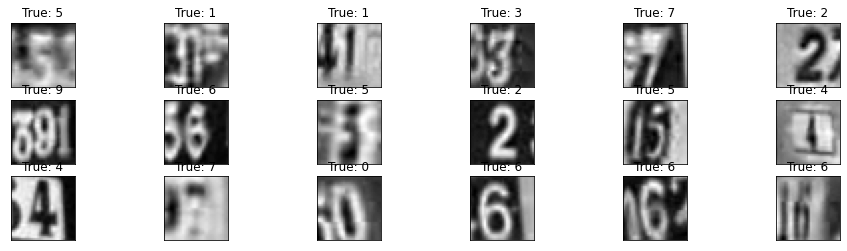

In [44]:
plot_images(X_train, 3, 6, y_train);



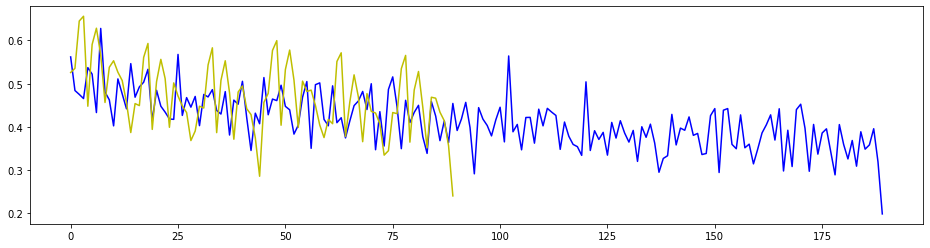

In [45]:
import matplotlib.pyplot as plt
plt.plot(train_loss ,'b')
plt.plot(valid_loss, 'y')
